In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv("mtcars.csv")
data["cyl"] = data["cyl"].replace({4: "low", 6: "medium", 8: "high"})
data["gear"] = data["gear"].replace({3: "A", 4: "B", 5: "C"})
data["cyl"] = pd.Categorical(data["cyl"], categories=["low", "medium", "high"], ordered=True)
data.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,medium,160.0,110,3.90,2.620,16.46,0,1,B,4
1,Mazda RX4 Wag,21.0,medium,160.0,110,3.90,2.875,17.02,0,1,B,4
2,Datsun 710,22.8,low,108.0,93,3.85,2.320,18.61,1,1,B,1
3,Hornet 4 Drive,21.4,medium,258.0,110,3.08,3.215,19.44,1,0,A,1
4,Hornet Sportabout,18.7,high,360.0,175,3.15,3.440,17.02,0,0,A,2


In [4]:
model = bmb.Model("mpg ~ 0 + hp * wt + cyl + gear", data)
idata = model.fit(draws=1000, target_accept=0.95, random_seed=1234)
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mpg_sigma, gear, cyl, hp:wt, wt, hp]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hp,-0.086,0.036,-0.154,-0.024,0.001,0.001,605.0,640.0,1.0
wt,-5.342,1.820,-8.533,-1.961,0.080,0.057,525.0,563.0,1.0
hp:wt,0.016,0.009,-0.001,0.034,0.000,0.000,541.0,608.0,1.0
cyl[low],41.526,5.218,31.549,50.703,0.232,0.164,516.0,517.0,1.0
cyl[medium],39.730,6.176,28.464,50.899,0.277,0.196,512.0,565.0,1.0
cyl[high],40.768,6.469,29.144,52.873,0.279,0.198,546.0,538.0,1.0
gear[B],1.369,1.454,-1.365,4.057,0.045,0.032,1045.0,1150.0,1.0
gear[C],2.160,2.059,-1.695,6.032,0.065,0.046,1013.0,1079.0,1.0
mpg_sigma,2.365,0.368,1.689,3.027,0.012,0.009,906.0,1119.0,1.0


In [5]:
def listify(obj):
    """Convert non-list objects to lists."""
    if obj is None:
        return []
    else:
        return obj if isinstance(obj, (list, tuple)) else [obj]

In [6]:
from statistics import mode

from pandas.api.types import is_categorical_dtype, is_numeric_dtype, is_string_dtype

def create_cap_data(model, covariates, grid_n=200, groups_n=5):
    """Create data for a Conditional Adjusted Predictions plot

    Parameters
    ----------
    model : bambi.Model
        An instance of a Bambi model
    covariates : list
        A sequence of one or two names of variables. The first variable is taken as the main 
        variable. If present, the second variable is a grouping variable.
    grid_n : int, optional
        The number of points used to evaluate the main covariate. Defaults to 200.
    groups_n : int, optional
        The number of groups to create when the grouping variable is numeric. Groups are based on
        equally spaced points. Defaults to 5.

    Returns
    -------
    pd.DataFrame
        The data for the Conditional Adjusted Predictions plot.

    Raises
    ------
    ValueError
        When the number of covariates is larger than 2.
    """
    data = model.data
    covariates = listify(covariates)
    
    if len(covariates) not in [1, 2]:
        raise ValueError("len(covariates) > 2")
    
    main = covariates[0]
  
    # If available, take the name of the grouping variable
    if len(covariates) == 1:
        group = None
    else:
        group = covariates[1]
    
    # Obtain data for main variable
    data_main = data[main]
    if is_numeric_dtype(data_main):
        main_values = np.linspace(np.min(data_main), np.max(data_main), grid_n)
    elif is_string_dtype(data_main) or is_categorical_dtype(data_main):
        main_values = np.unique(data_main)
    else:
        raise ValueError("Bad type")
    
    # If available, obtain groups for grouping variable
    if group:
        group_data = data[group]
        if is_string_dtype(group_data) or is_categorical_dtype(group_data):
            group_values = np.unique(group_data)
        elif is_numeric_dtype(group_data):
            group_values = np.quantile(group_data, np.linspace(0, 1, groups_n))   
        else:
            raise ValueError("Bad type")
        
        # Reshape accordingly         
        group_n = len(group_values)
        main_n = len(main_values)
        main_values = np.tile(main_values, group_n)
        group_values = np.repeat(group_values, main_n)
        data_dict = {main: main_values, group: group_values}
    else:
        data_dict = {main: main_values}
        
    # Construct dictionary of terms that are in the model
    terms = {}
    if model._design.common:
        terms.update(model._design.common.terms)
    
    if model._design.group:
        terms.update(model._design.group.terms)
    
    # Get default values for each variable in the model
    for term in terms.values():
        if hasattr(term, "components"):
            for component in term.components:
                name = component.name
                # For numeric predictors, select the mean.
                if component.kind == "numeric":
                    if name not in data_dict:
                        data_dict[name] = np.mean(data[name])
                # For categoric predictors, select the most frequent level.
                elif component.kind == "categoric":
                    if name not in data_dict:
                        data_dict[name] = mode(data[name])
    
    
    cap_data = pd.DataFrame(data_dict)
    
    # Make sure new types have same types than the originals
    for column in cap_data:
        cap_data[column] = cap_data[column].astype(data[column].dtype)
    return cap_data

In [7]:
create_cap_data(model, ["gear", "cyl"])

,gear,cyl,hp,wt
0,A,high,146,3.21725
1,B,high,146,3.21725
2,C,high,146,3.21725
3,A,low,146,3.21725
4,B,low,146,3.21725
5,C,low,146,3.21725
6,A,medium,146,3.21725
7,B,medium,146,3.21725
8,C,medium,146,3.21725


In [8]:
create_cap_data(model, ["wt", "cyl"])

,wt,cyl,hp,gear
0,1.513000,high,146,A
1,1.532653,high,146,A
2,1.552307,high,146,A
3,1.571960,high,146,A
4,1.591613,high,146,A
...,...,...,...,...
595,5.345387,medium,146,A
596,5.365040,medium,146,A
597,5.384693,medium,146,A
598,5.404347,medium,146,A


In [9]:
d = create_cap_data(model, ["wt", "cyl"])

In [10]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def get_unique_levels(x):
    if hasattr(x, "dtype") and hasattr(x.dtype, "categories"):
        levels = list(x.dtype.categories)
    else:
        levels = np.unique(x)
    return levels


def plot_cap(model, idata, covariates, level=0.95, figsize=(8, 5), ax=None):
    
    covariates = listify(covariates)
    assert len(covariates) in [1, 2]
    
    cap_data = create_cap_data(model, covariates)
    idata = model.predict(idata, data=cap_data, inplace=False)
  
    lb = round((1 - level) / 2, 4)
    ub = 1 - lb
  
    y_hat = idata.posterior[f"{model.response.name}_mean"]
    y_hat_mean = y_hat.mean(("chain", "draw"))
    y_hat_bounds = y_hat.quantile(q=(lb, ub), dim=("chain", "draw"))
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()
    
    if is_numeric_dtype(cap_data[covariates[0]]):
        ax = _plot_cap_numeric(covariates, cap_data, y_hat_mean, y_hat_bounds, ax)
    elif is_categorical_dtype(cap_data[covariates[0]]) or is_string_dtype(cap_data[covariates[0]]):
        ax = _plot_cap_categoric(covariates, cap_data, y_hat_mean, y_hat_bounds, ax)
    else:
        raise ValueError("Bad type")
        
    return fig, ax


def _plot_cap_numeric(covariates, cap_data, y_hat_mean, y_hat_bounds, ax):
    if len(covariates) == 1:
        main = covariates[0]
        ax.plot(cap_data[main], y_hat_mean);
        ax.fill_between(cap_data[main], y_hat_bounds[0], y_hat_bounds[1], alpha=0.5)
    else:
        main, group = covariates
        groups = get_unique_levels(cap_data[group])
            
        for i, grp in enumerate(groups):
            idx = (cap_data[group] == grp).values
            ax.plot(cap_data.loc[idx, main], y_hat_mean[idx], color=f"C{i}");
            ax.fill_between(
                cap_data.loc[idx, main], 
                y_hat_bounds[0][idx], 
                y_hat_bounds[1][idx], 
                alpha=0.3,
                color=f"C{i}"
            )
            
        handles = [
            (
                Line2D([], [], color=f"C{i}", solid_capstyle="butt"),
                Patch(color=f"C{i}", alpha=0.3, lw=1) 
            )
            for i in range(len(groups))
        ]
        
        ax.legend(
            handles, 
            tuple(groups), 
            title=group, 
            handlelength=1.3, 
            handleheight=1.15,
            bbox_to_anchor=(1.03, 0.5), 
            loc="center left"
        )
            
    ax.set(xlabel=main, ylabel=model.response.name)
    return ax
    
    
def _plot_cap_categoric(covariates, cap_data, y_hat_mean, y_hat_bounds, ax):
    main = covariates[0]
    main_levels = get_unique_levels(cap_data[main])
    main_levels_n = len(main_levels)
    idxs_main = np.arange(main_levels_n)
    
    if len(covariates) == 1:
        ax.scatter(idxs_main, y_hat_mean);
        ax.vlines(idxs_main, y_hat_bounds[0], y_hat_bounds[1])
    else:
        group = covariates[1]
        group_levels = get_unique_levels(cap_data[group])
        group_levels_n = len(group_levels)
        offset_groups = np.linspace(-0.3, 0.3, group_levels_n)
        
        for i, grp in enumerate(group_levels):
            idx = (cap_data[group] == grp).values
            idxs = idxs_main + offset_groups[i]
            ax.scatter(idxs, y_hat_mean[idx], color=f"C{i}")
            ax.vlines(idxs, y_hat_bounds[0][idx], y_hat_bounds[1][idx], color=f"C{i}")
            
        handles = [
            Line2D([], [], c=f"C{i}", marker="o", label=level) 
            for i, level in enumerate(group_levels)
        ]
        
        ax.legend(handles=handles, title=group, bbox_to_anchor=(1.03, 0.5), loc="center left")
            
    ax.set(xlabel=main, ylabel=model.response.name)
    ax.set_xticks(idxs_main)
    ax.set_xticklabels(main_levels)
    return ax

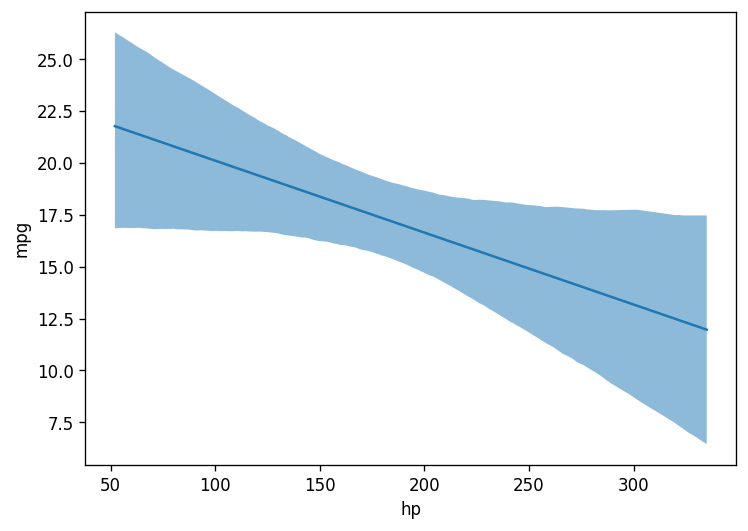

In [11]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=120)
plot_cap(model, idata, "hp", ax=ax);

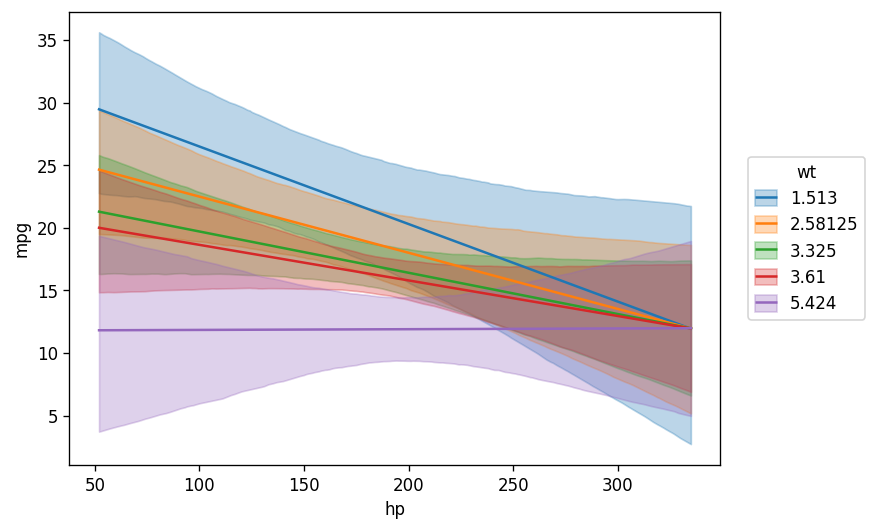

In [12]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=120)
plot_cap(model, idata, ["hp", "wt"], ax=ax);

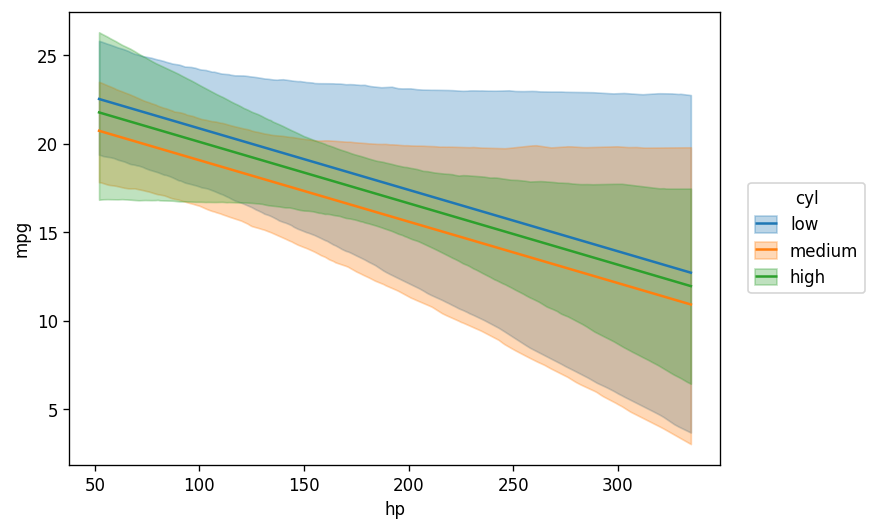

In [13]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=120)
plot_cap(model, idata, ["hp", "cyl"], ax=ax);

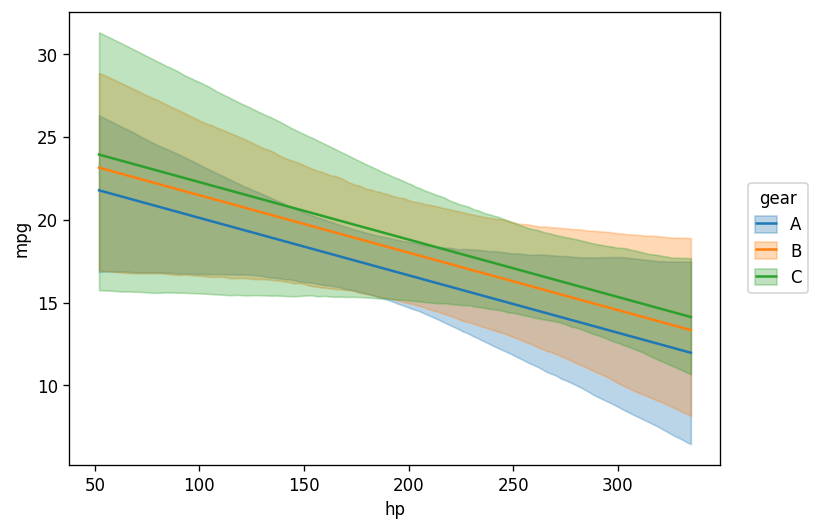

In [14]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=120)
plot_cap(model, idata, ["hp", "gear"], ax=ax);

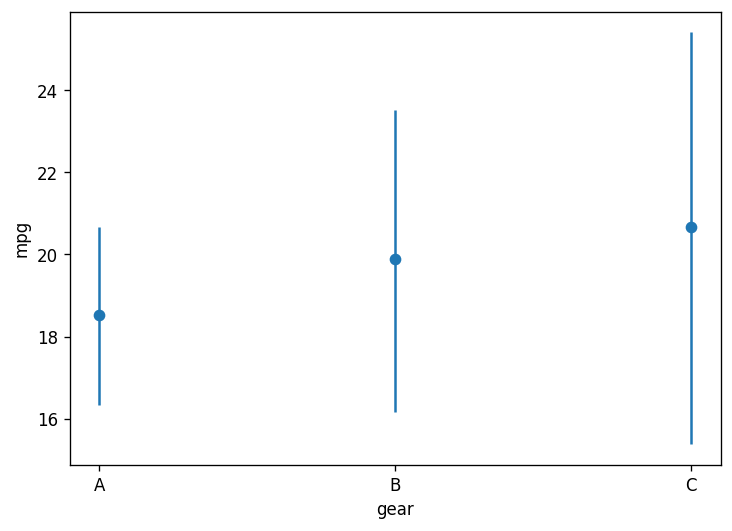

In [15]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=120)
plot_cap(model, idata, ["gear"], ax=ax);

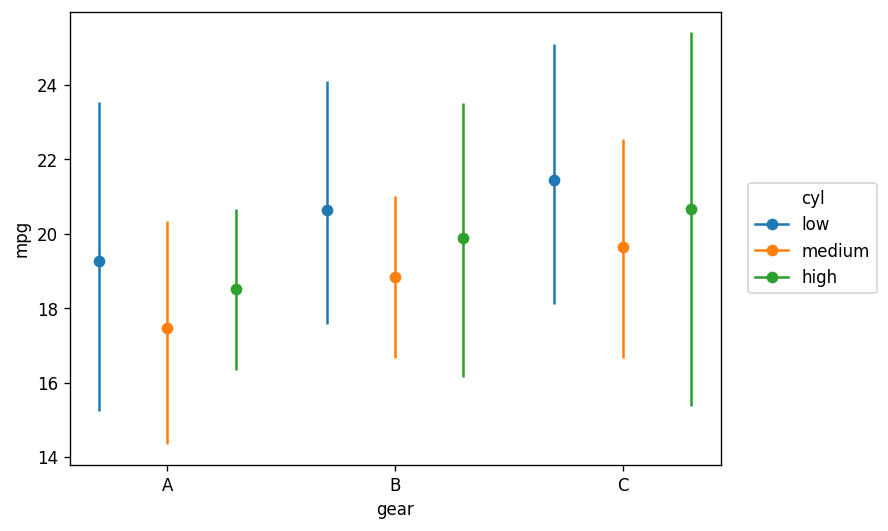

In [16]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=120)
plot_cap(model, idata, ["gear", "cyl"], ax=ax);

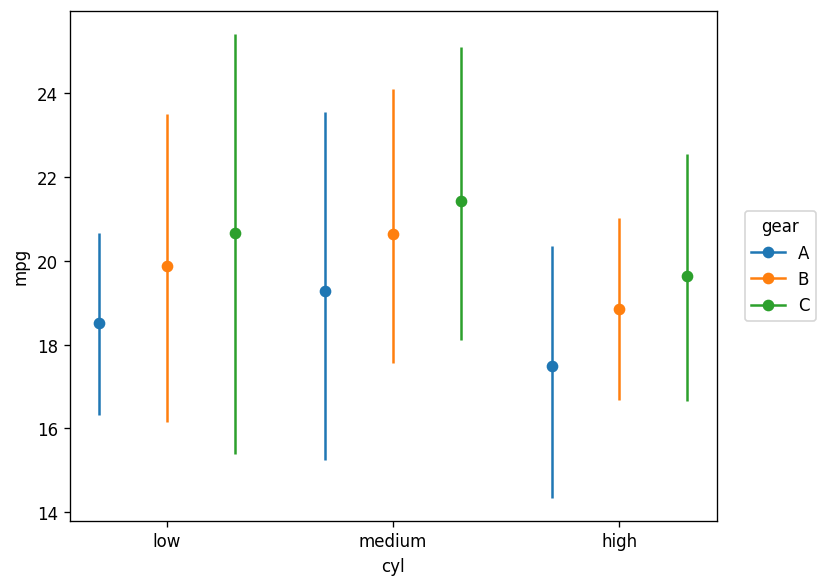

In [17]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=120, tight_layout=True)
plot_cap(model, idata, ["cyl", "gear"], ax=ax);
fig.set_facecolor("w")
fig.savefig("plot.png")

# Case study

In [76]:
data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/ggplot2movies/movies.csv")

In [77]:
data["style"] = "Other"
data.loc[data["Action"] == 1, "style"] = "Action"
data.loc[data["Comedy"] == 1, "style"] = "Comedy"
data.loc[data["Drama"] == 1, "style"] = "Drama"
data["certified_fresh"] = (data["rating"] >= 8) * 1
data = data[data["length"] < 240]

In [79]:
priors = {"style": bmb.Prior("Normal", mu=0, sigma=2)}
model = bmb.Model("certified_fresh ~ 0 + length * style", data=data, priors=priors, family="bernoulli")
model

Formula: certified_fresh ~ 0 + length * style
Family name: Bernoulli
Link: logit
Observations: 58662
Priors:
  Common-level effects
    length ~ Normal(mu: 0.0, sigma: 0.0708)
    style ~ Normal(mu: 0, sigma: 2)
    length:style ~ Normal(mu: [0. 0. 0.], sigma: [0.0702 0.0509 0.0611])

In [80]:
idata = model.fit(random_seed=1234, target_accept=0.9, init="adapt_diag")

Modeling the probability that certified_fresh==1
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [length:style, style, length]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 380 seconds.
The number of effective samples is smaller than 25% for some parameters.


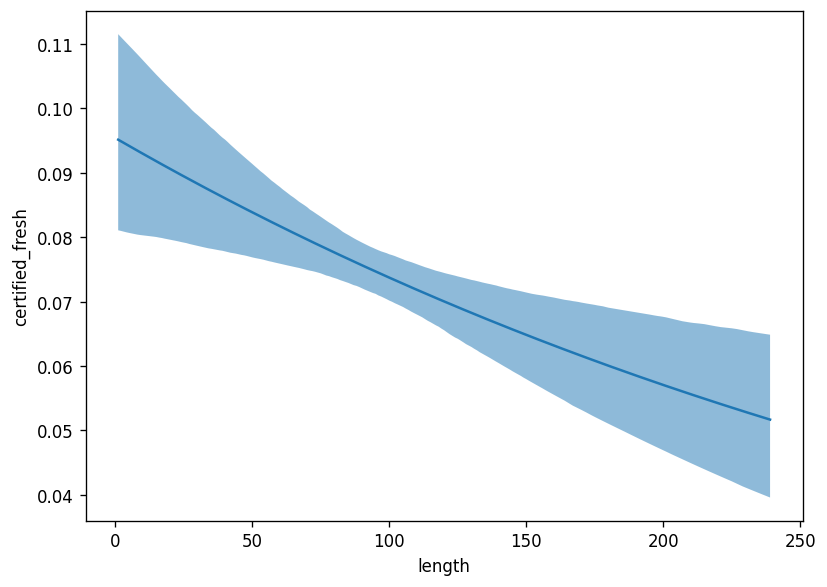

In [88]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=120, tight_layout=True)
plot_cap(model, idata, "length", ax=ax)
fig.set_facecolor("w")
fig.savefig("plot1.png")

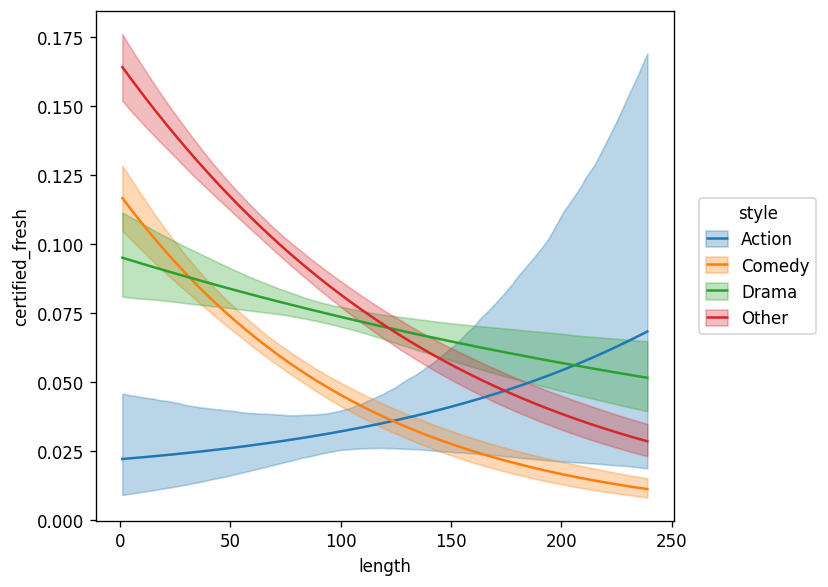

In [87]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=120, tight_layout=True)
plot_cap(model, idata, ["length", "style"], ax=ax)
fig.set_facecolor("w")
fig.savefig("plot2.png")

Extra: 

This model is a good example to show that sometimes `adapt_diag+jitter` is no good!

Hint: The model never finishes sampling. Chains don't mix. All types of problems!